### Copyright 2023 Google LLC
### only non-commercial use with attribution to Author

### **_NOTE_**: This notebook has been tested in the GCP environment:


***_Author_*** :  Saurabh Mangal

* Python version = 3.10.13
* Do install all dependencies as well as keys -- also need to logiin to HF

## This Code can run on a SINGLE L4 Google Cloud notebook workbench instance 

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

## # # install the packages

In [4]:

# !pip install git+https://github.com/huggingface/diffusers.git
# !pip install transformers sentencepiece accelerate protobuf

In [5]:
import torch
torch.Tensor.device

<attribute 'device' of 'torch._C.TensorBase' objects>

In [6]:
import torch
print(torch.__version__)

2.4.0+cu121


In [7]:
# import torch
# from diffusers import FluxPipeline
# import diffusers
# from PIL import Image
# import matplotlib.pyplot as plt

# # Modify the rope function to handle CUDA device
# _flux_rope = diffusers.models.transformers.transformer_flux.rope
# def new_flux_rope(pos: torch.Tensor, dim: int, theta: int) -> torch.Tensor:
#     assert dim % 2 == 0, "The dimension must be even."
#     if pos.device.type == "cuda":
#         # Move tensor to CPU for ROPE computation, then move it back to CUDA
#         return _flux_rope(pos.to("cpu"), dim, theta).to(device=pos.device)
#     else:
#         # Perform ROPE computation directly if tensor is not on CUDA
#         return _flux_rope(pos, dim, theta)
# diffusers.models.transformers.transformer_flux.rope = new_flux_rope

# # Load the Flux Schnell model
# pipe = FluxPipeline.from_pretrained(
#     "black-forest-labs/FLUX.1-schnell",
#     revision='refs/pr/1',
#     torch_dtype=torch.bfloat16 #bfloat16
# ).to("cuda")

# print("this is done ...")
# # pipe = FluxPipeline.from_pretrained(
# #     ckpt_id,
# #     torch_dtype=torch.float16,  # Use float16 for quantization
# # )

# # Quantize the model
# pipe.unet = bnb.nn.Linear8bitLt.from_module(pipe.unet, torch_dtype=torch.float16)

# # Enable optimizations
# pipe.vae.enable_tiling()
# pipe.vae.enable_slicing()
# pipe.enable_sequential_cpu_offload()

# # image = pipe(prompt).images[0]



In [8]:

# # Define the prompt
# # This is the textual description that the model will use to generate the image
# prompt = "A modern, minimalist house with cute girls with large windows and a flat roof."

# # Generate the image
# out = pipe(
#     prompt=prompt,
#     guidance_scale=0.,
#     height=1024,
#     width=1024,
#     num_inference_steps=4,
#     max_sequence_length=256,
# ).images[0]

# # Save the generated image
# out.save("gen_image.png")

# # Display the generated image
# image = Image.open("gen_image.png")
# plt.imshow(image)
# plt.axis('off')  # Hide axes
# plt.show()

In [29]:
# !pip install git+https://github.com/huggingface/diffusers.git
# !pip install transformers sentencepiece accelerate protobuf

In [31]:
### !huggingface-cli  ### or do this next one
# !pip install huggingface_hub

from huggingface_hub import notebook_login


# !hf_Hk__QfzHN--L--bcikmwSDtxrlOZFoQIqlhSFndz (not the real token)

## Main Model loading code

In [10]:
import torch
from diffusers import FluxTransformer2DModel, FluxPipeline
from transformers import T5EncoderModel, CLIPTextModel
from optimum.quanto import freeze, qfloat8, quantize

bfl_repo = "black-forest-labs/FLUX.1-dev"
dtype = torch.bfloat16

transformer = FluxTransformer2DModel.from_single_file("https://huggingface.co/Kijai/flux-fp8/blob/main/flux1-dev-fp8.safetensors", torch_dtype=dtype)
quantize(transformer, weights=qfloat8)
freeze(transformer)

text_encoder_2 = T5EncoderModel.from_pretrained(bfl_repo, subfolder="text_encoder_2", torch_dtype=dtype)
quantize(text_encoder_2, weights=qfloat8)
freeze(text_encoder_2)

pipe = FluxPipeline.from_pretrained(bfl_repo, transformer=None, text_encoder_2=None, torch_dtype=dtype)
pipe.transformer = transformer
pipe.text_encoder_2 = text_encoder_2

pipe.enable_model_cpu_offload()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


## Change the prompt

In [27]:

prompt = 'nice  simple indian girl eating choclate in nature' #"A simple dog holding a simple basket "
image = pipe(
    prompt,
    guidance_scale=3.5,
    output_type="pil",
    num_inference_steps=8,
    generator=torch.Generator("cuda").manual_seed(3)
).images[0]

image.save("flux-fp8-dev.png")

  0%|          | 0/8 [00:00<?, ?it/s]

## Visualize the outputs

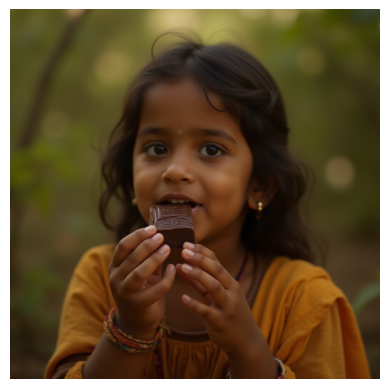

In [28]:
# # Display the generated image

from PIL import Image
import matplotlib.pyplot as plt


image = Image.open("flux-fp8-dev.png")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

{TODO: Include commands to delete individual resources below}